In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from _schon import ContinuousSIS
import horgg
import argparse
import json
import pickle
import ray
from time import time

In [3]:
# Start Ray.
ray.shutdown()
ray.init(num_cpus=10)

2023-02-09 08:38:51,474	INFO worker.py:1538 -- Started a local Ray instance.


Python version:,3.10.8
Ray version:,2.2.0


## Preprocessing

### Configuration

In [4]:
config_file = './dat/conf_exp1.json'

with open(config_file, 'r') as file:
    config = json.load(file)

In [5]:
exp_id = 10

### Unpack

In [6]:
#structure
nmax = config['nmax']
mmax = config['mmax']
mmin = config['mmin']
qm = np.array(config['qm'])
pn = np.array(config['pn'])

#rate
py_n = np.array(config['py_n'])
ymax = config['ymax']
rate = np.array(config['rate'])
mean_rate = config['mean_rate']

#contagion
# initial_infected_fraction = config['initial_density']
initial_infected_fraction = 10**(-4)

### Generate random network

In [7]:
#generate sequences
np.random.seed(42) #optional, if nothing is given, it is seeded with time
N = 200000 #number of groups
n_list = horgg.utility.sequence_1(N, pn)
m_list = horgg.utility.sequence_2(n_list, qm)

graph_generator = horgg.BCMS(m_list,n_list)
# horgg.BCMS.seed(42) #optional, if nothing is given, it is seeded with time

#mcmc steps are additional edge swaps to ensure uniformity, I recommend O(N)
edge_list = graph_generator.get_random_graph(nb_steps=N)

In [8]:
#get group list, i.e., list of nodes in the groups
groups = [[] for _ in range(N)]
membership = [[] for _ in range(len(m_list))]
for edge in edge_list:
    groups[edge[1]].append(edge[0])
    membership[edge[0]].append(edge[1])
groups = np.array(groups)
print(len(membership),len(groups))

100000 200000


### Prepare group transmission rates

In [239]:
pdf = py_n[:,nmax]
cum = np.cumsum(pdf)
group_transmission_rate = []
for _ in range(N):
    r = np.random.random()
    ind = np.searchsorted(cum,r)
    group_transmission_rate.append(rate[ind])

In [240]:
print(np.mean(group_transmission_rate))

0.0061044338730000015


### Prepare infection / recovery rate

In [241]:
recovery_rate = 1.
infection_rate = np.zeros((nmax+1,nmax+1))
for n in range(2,nmax+1):
    for i in range(nmax+1):
        infection_rate[n][i] = i

## Simulation

In [242]:
takeoff = False
while not takeoff:
    cont = ContinuousSIS(edge_list,recovery_rate,infection_rate,
                            group_transmission_rate)
    cont.measure_prevalence()
    cont.measure_time()
    cont.measure_infectious_set()

    cont.infect_fraction(initial_infected_fraction)

    #evolve and measure
    dt = 20
    dec_dt = 0.
    cont.evolve(dt,dec_dt,measure=True,quasistationary=False)
    
    #get the result measure
    for measure in cont.get_measure_vector():
        name = measure.get_name()
        if name == "time":
            time_list_ = list(measure.get_result()).copy()
        elif name == "infectious_set":
            infectious_set_list_ = list(measure.get_result()).copy()
        elif name == "prevalence":
            prevalence_list_ = list(measure.get_result()).copy()
    if prevalence_list_[-1] >= 10**(-3):
        takeoff = True

In [243]:
ind = np.argmin(np.abs(np.array(prevalence_list_)-0.001))

In [244]:
time_list = time_list_[:ind]
infectious_set_list = infectious_set_list_[:ind]
prevalence_list = prevalence_list_[:ind]
len(prevalence_list)

1222

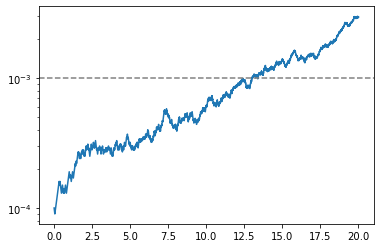

In [245]:
plt.semilogy(time_list_,prevalence_list_)
plt.axhline(0.001, ls='--', color='grey')

### Get events

In [246]:
event_list = []
for i in range(len(infectious_set_list)-1):
    if len(infectious_set_list[i+1]) > len(infectious_set_list[i]):
        #infection
        (node,) = infectious_set_list[i+1] - infectious_set_list[i] #tuple unpacking from a set
        infection_event = True
    else:
        (node,) = infectious_set_list[i] - infectious_set_list[i+1] #tuple unpacking from a set
        infection_event = False
    event_list.append((infection_event,node))

## Measure likelihood

In [247]:
def get_total_rate(infectious_set, groups, beta, nu):
    total_rate = len(infectious_set) #recovery events
    for group in groups:
        n = len(group)
        i = 0
        for node in group:
            if node in infectious_set:
                i+= 1
        total_rate += (n-i)*beta*i**nu
    return total_rate

def rates_infection_event(infectious_set,groups_sub,beta,nu):
    #infectious_set prior to event
    #groups_sub is a subset of groups where new infectious node belongs to
    rate_prior = 0
    rate_now = 0
    node_rate = 0
    for group in groups_sub:
        n = len(group)
        i = 0
        for node_ in group:
            if node_ in infectious_set:
                i += 1
        rate_prior += (n-i)*beta*i**nu
        rate_now += (n-(i+1))*beta*(i+1)**nu
        node_rate += beta*i**nu
    if node_rate == 0:
        raise RuntimeError("node_rate is 0")
    return node_rate,rate_prior,rate_now
    
def rates_recovery_event(infectious_set,groups_sub,beta,nu):
    #infectious_set prior to event
    #groups_sub is a subset of groups where new old node belongs to
    rate_prior = 0
    rate_now = 0
    for group in groups_sub:
        n = len(group)
        i = 0
        for node_ in group:
            if node_ in infectious_set:
                i += 1
        rate_prior += (n-i)*beta*i**nu
        rate_now += (n-(i-1))*beta*(i-1)**nu
    return rate_prior,rate_now   

def get_loglikelihood(time_list, infectious_set_list, event_list, groups, membership, beta, nu):        
    ll = 0
    total_rate = get_total_rate(infectious_set_list[0], groups, beta, nu)
    for i in range(len(time_list)-1):
        infectious_set = infectious_set_list[i].copy()
        dt = time_list[i+1]-time_list[i]
        event = event_list[i]
        infection_event,node = event[0],event[1]
        groups_sub = [groups[g] for g in membership[node]]
        node_rate = 0.
        if infection_event:
            assert node in infectious_set_list[i+1] - infectious_set_list[i]
            node_rate,rate_prior,rate_now = rates_infection_event(infectious_set,groups_sub,beta,nu)
        else:
            assert node in infectious_set_list[i] - infectious_set_list[i+1]
            rate_prior,rate_now = rates_recovery_event(infectious_set,groups_sub,beta,nu)
            node_rate = 1
        ll += -total_rate*dt + np.log(node_rate)
        #update total rate
        total_rate += (rate_now - rate_prior)
    return ll

In [248]:
beta_list = np.linspace(0.004,0.008,30)
nu_list = np.linspace(1.,3.,50)
Beta,Nu = np.meshgrid(beta_list,nu_list)

In [249]:
@ray.remote
def target(beta,nu):
    return get_loglikelihood(time_list, infectious_set_list, event_list, groups, membership, beta, nu)

In [250]:
# Start the tasks in parallel.
t1 = time()
result_ids = []
for beta,nu in zip(Beta.flatten(),Nu.flatten()):
    result_ids.append(target.remote(beta,nu))
results = ray.get(result_ids)
t2 = time()
print(f"It took {t2-t1} seconds")

2023-01-22 21:33:40,776	WARNING worker.py:1404 -- Warning: The remote function __main__.target is very large (24 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
(target pid=17003) E0122 21:33:40.907970000 6325039104 chttp2_transport.cc:1103]          Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(target pid=16999) E0122 21:33:40.907684000 6325039104 chttp2_transport.cc:1103]          Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(target pid=16995) E0122 21:33:40.907634000 6341865472 chttp2_transport.cc:1103]          Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(target pid=16998) E0122 21:33:40.908251000 6348173312 chttp2_transport.cc:1103]          Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_ma

It took 45.992456912994385 seconds


In [251]:
LL = np.array(results).reshape(Beta.shape)

In [252]:
LL -= np.amax(LL)
LH = np.exp(LL)

Text(0, 0.5, '$\\nu$')

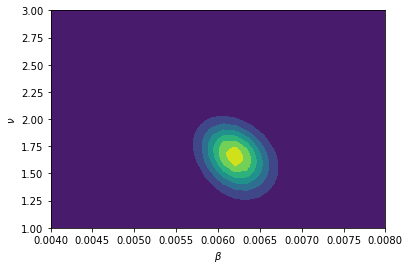

In [253]:
plt.contourf(Beta,Nu,LH)
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\nu$')

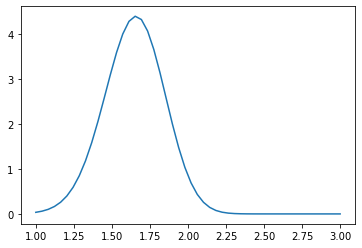

In [254]:
plt.plot(nu_list,np.sum(LH,axis=1))

## Save the results

In [255]:
data = {'beta':Beta.flatten(), 'nu':Nu.flatten(), 'll':LL.flatten()}
df = pd.DataFrame(data)
df['exp_id'] = exp_id
df.to_parquet(f'./dat/loglikelihood_{exp_id}.pq')

In [256]:
data = {'time':time_list_, 'prevalence':prevalence_list_, 'infectious':infectious_set_list_}
df = pd.DataFrame(data)
df['exp_id'] = exp_id
df['cut'] = 10**(-3)
df.to_parquet(f'./dat/timeseries_{exp_id}.pq')